In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corrcal
import hera_sim
import healpy
import os
import vis_cpu
from astropy import constants, units
from astropy.time import Time
from astropy.coordinates import Longitude, Latitude, EarthLocation
from scipy.optimize import minimize
from scipy import special
from pyuvdata import UVBeam
from pyradiosky import SkyModel
%matplotlib inline

In [2]:
beam_file = "NF_HERA_Dipole_efield_beam.fits"
hpx_beam_file = "NF_HERA_dipole_linpol_power_healpix128.fits"
gleam_file = "gleam-120.02-127.34MHz-nf-76-pld.skyh5"
egsm_file = "egsm_pred_50_200mhz.h5.npz"
array_file = "array_layout.csv"
haslam_file = "haslam408_dsds_Remazeilles2014.fits"
for f in (beam_file, hpx_beam_file, gleam_file, egsm_file, array_file, haslam_file):
    assert os.path.exists(f)

In [733]:
gleam_model = SkyModel.from_skyh5(gleam_file)

In [734]:
min_flux = 50  # Jy
max_flux = 200  # Jy
gleam_model.source_cuts(min_flux=min_flux, max_flux=max_flux, inplace=True)

In [735]:
uvbeam = UVBeam.from_file(beam_file, file_type="beamfits")

In [736]:
hpx_uvbeam = UVBeam.from_file(hpx_beam_file, file_type="beamfits")

In [737]:
select_freq = 125e6

In [738]:
with np.load(egsm_file) as egsm_npz:
    egsm_freqs = egsm_npz["freqs"] * 1e9  # Convert to Hz
    egsm_imap = egsm_npz["imap"] * 1e6  # Convert to Jy/sr

In [739]:
egsm_stokes = np.zeros((4,) + egsm_imap.shape, dtype=egsm_imap.dtype)
egsm_stokes[0,...] = egsm_imap
del egsm_imap

In [740]:
gleam_freqs = gleam_model.freq_array.si.value.squeeze()
uvbeam_freqs = uvbeam.freq_array.squeeze()
hpx_uvbeam_freqs = hpx_uvbeam.freq_array.squeeze()
# gleam_select = [np.argmin(np.abs(gleam_freqs - select_freq))]
# uvb_select = [np.argmin(np.abs(uvbeam_freqs - select_freq))]
# hpx_uvb_select = [np.argmin(np.abs(hpx_uvbeam_freqs - select_freq))]
# egsm_select = [np.argmin(np.abs(egsm_freqs - select_freq))]
fq_min = gleam_freqs[0]
fq_max = gleam_freqs[-1]
df_uvb = np.mean(np.diff(uvbeam_freqs))
df_egsm = np.mean(np.diff(egsm_freqs))
egsm_select = np.argwhere((egsm_freqs+df_egsm >= fq_min) & (egsm_freqs-df_egsm <= fq_max)).flatten()
uvb_select = np.argwhere((uvbeam_freqs+df_uvb >= fq_min) & (uvbeam_freqs-df_uvb <= fq_max)).flatten()
hpx_uvb_select = np.argwhere((hpx_uvbeam_freqs+df_uvb >= fq_min) & (hpx_uvbeam_freqs-df_uvb <= fq_max)).flatten()

In [741]:
egsm_freqs = egsm_freqs[egsm_select]
egsm_stokes = egsm_stokes[:,egsm_select,:]

In [742]:
uvbeam.select(freq_chans=uvb_select)

In [743]:
hpx_uvbeam.select(freq_chans=hpx_uvb_select)

In [744]:
uvbeam.freq_interp_kind = "cubic"
uvbeam.interpolation_function = "az_za_simple"
hpx_uvbeam.freq_interp_kind = "cubic"
hpx_uvbeam.interpolation_function = "healpix_simple"

In [745]:
uvbeam = uvbeam.interp(freq_array=gleam_freqs, new_object=True)

In [746]:
hpx_uvbeam = hpx_uvbeam.interp(freq_array=gleam_freqs, new_object=True)

In [747]:
# Do the select on the GLEAM model
# gleam_model.at_frequencies(np.array([select_freq,])*units.Hz, inplace=True)

In [748]:
egsm_npix = egsm_stokes.shape[-1]
egsm_nside = healpy.npix2nside(egsm_npix)
egsm_ipix = np.arange(egsm_npix)

In [749]:
uvb_nside = hpx_uvbeam.nside
uvb_npix = healpy.nside2npix(uvb_nside)
uvb_ipix = np.arange(uvb_npix)

In [750]:
# Rotate eGSM to equatorial coordinates so we can load into a SkyModel
egsm_lmax = 3*egsm_nside - 1
psi, theta, phi = healpy.rotator.coordsys2euler_zyz("GC")  # Galactic to Equatorial transformation
for i in range(egsm_freqs.size):
    egsm_alm = healpy.sphtfunc.map2alm(egsm_stokes[0,i], lmax=egsm_lmax, use_pixel_weights=True)
    healpy.rotate_alm(egsm_alm, psi=psi, theta=theta, phi=phi, lmax=egsm_lmax)
    new_imap = healpy.alm2map(egsm_alm, egsm_nside, egsm_lmax)
    egsm_stokes[0,i] = new_imap
    # Rather than directly use the eGSM (we'll do that later), get its power spectrum...
#     egsm_cls = healpy.sphtfunc.anafast(new_imap, lmax=egsm_lmax, use_pixel_weights=True)
    # and use a realization of a GRF with that power spectrum
#     egsm_stokes[0,i] = healpy.sphtfunc.synfast(egsm_cls, egsm_nside)
del egsm_alm, new_imap

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [751]:
egsm_model = SkyModel(
    stokes=egsm_stokes*units.Jy/units.sr,
    spectral_type="subband",
    freq_array=egsm_freqs*units.Hz,
    component_type="healpix",
    nside=egsm_nside,
    hpx_inds=egsm_ipix,
    hpx_order="ring",
)

In [752]:
array_layout = hera_sim.antpos.hex_array(3, split_core=False, outriggers=0)
start_time = 2458099.438783255  # JD; a few bright point sources overhead
integration_time = 10.7  # seconds
Ntimes = 1
start_freq = select_freq
channel_width = 1e6
Nfreqs = 1
polarization_array = [-5, -6, -7, -8]
uvdata = hera_sim.io.empty_uvdata(
    array_layout=array_layout,
    Nfreqs=Nfreqs,
    start_freq=start_freq,
    channel_width=channel_width,
    Ntimes=Ntimes,
    start_time=start_time,
    integration_time=integration_time,
    polarization_array=polarization_array,
)
uvdata.integration_time = np.ones(uvdata.Nbls) * integration_time
uvdata.channel_width = channel_width

Fixing phases using antenna positions.


In [753]:
beam_ids = dict.fromkeys(uvdata.antenna_numbers.astype(str), 0)
beams = [uvbeam,]

In [754]:
gleam_data_model = hera_sim.visibilities.ModelData(
    uvdata=uvdata.copy(),
    sky_model=gleam_model,
    beam_ids=beam_ids,
    beams=beams,
    normalize_beams=True,
)

All polarized beams have x_orientation set to None. This will make it hard to interpret the polarizations of the simulated visibilities.


In [755]:
egsm_data_model = hera_sim.visibilities.ModelData(
    uvdata=uvdata.copy(),
    sky_model=egsm_model,
    beam_ids=beam_ids,
    beams=beams,
    normalize_beams=True,
)

In [756]:
gleam_sim = hera_sim.visibilities.VisibilitySimulation(
    data_model=gleam_data_model,
    simulator=hera_sim.visibilities.VisCPU(),
)

In [757]:
_ = gleam_sim.simulate();

In [758]:
uvdata.data_array += gleam_sim.uvdata.data_array
uvdata.history += f"\n{gleam_sim.uvdata.history}"

In [759]:
del gleam_sim, gleam_data_model

In [760]:
egsm_sim = hera_sim.visibilities.VisibilitySimulation(
    data_model=egsm_data_model,
    simulator=hera_sim.visibilities.VisCPU(),
    n_side=egsm_nside,
)

In [761]:
_ = egsm_sim.simulate();

In [762]:
uvdata.data_array += egsm_sim.uvdata.data_array*0
uvdata.history += f"\n{egsm_sim.uvdata.history}"

In [763]:
del egsm_sim, egsm_data_model

In [839]:
len(edges) - 1

15

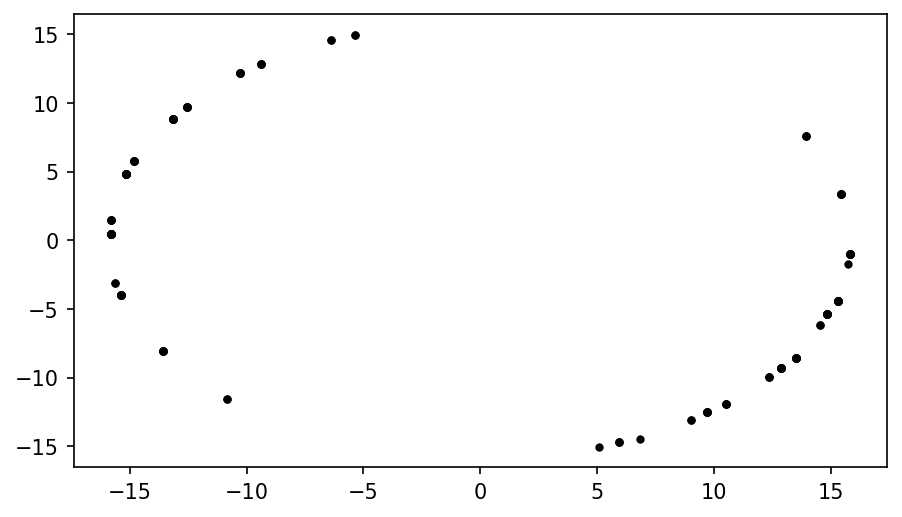

In [764]:
# Sanity check: do the visibilities look sensible?
x = np.argwhere(uvdata.ant_1_array != uvdata.ant_2_array)  # No autos please
plt.figure(figsize=(7,4),dpi=150,facecolor='w')
plt.scatter(uvdata.data_array[x,0,0,0].real, uvdata.data_array[x,0,0,0].imag, c='k', marker='.');

Next steps:
<br>
* Rotate the eGSM to the correct position for the mock observation.
* Calculate the angular power spectra for the (horizon-truncated) beam and the rotated eGSM.
* Calculate the diffuse and source matrices.
* Run CorrCal!

In [765]:
# First, let's select only the cross-correlations and group by redundancy
uvdata.select(ant_str="cross", inplace=True)

In [766]:
# Also do a select to ensure a reasonable number of baselines per redundant group
groups, centers, lengths = uvdata.get_redundancies()
bls_to_keep = []
for group in groups:
    if len(group) >= 5:
        bls_to_keep += group
uvdata.select(bls=bls_to_keep)

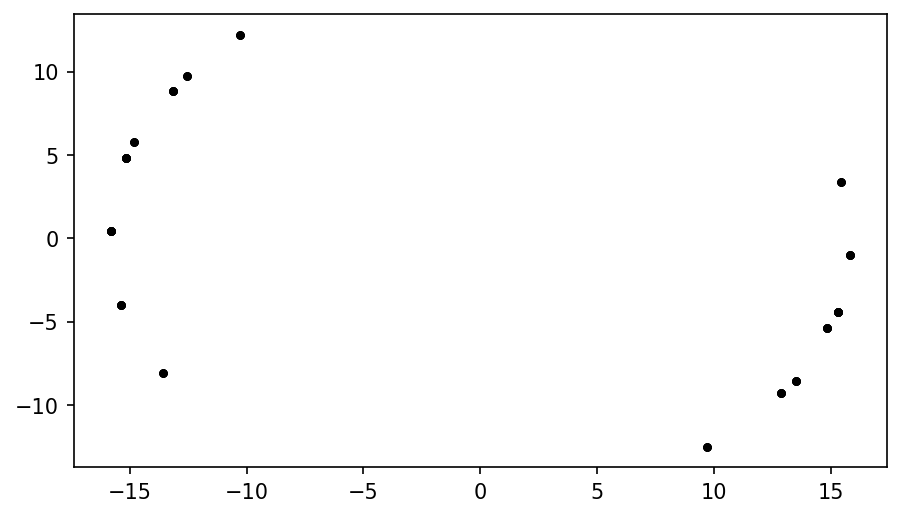

In [841]:
# Sanity check: do the visibilities look sensible? Check after select
plt.figure(figsize=(7,4),dpi=150,facecolor='w')
plt.scatter(uvdata.data_array[:,0,0,0].real, uvdata.data_array[:,0,0,0].imag, c='k', marker='.');

In [767]:
# First pull the data and relevant metadata
antpos, antenna_numbers = uvdata.get_ENU_antpos()
ant_1_array = uvdata.ant_1_array
ant_2_array = uvdata.ant_2_array
ant_1_inds = np.zeros_like(ant_1_array)
ant_2_inds = np.zeros_like(ant_2_array)
data = uvdata.data_array[:,0,0,0].copy()
for i, ant in enumerate(antenna_numbers):
    ant_1_inds[ant_1_array==ant] = i
    ant_2_inds[ant_2_array==ant] = i

In [768]:
# Now group by redundancy
wavelength = constants.c.si.value / select_freq
uvws = (antpos[ant_2_inds] - antpos[ant_1_inds]) / wavelength
sort, edges, conj = corrcal.gridding.make_redundant_groups(*uvws.T[:2])
sorted_uvws = uvws[sort,:]
sorted_uvws[conj,:] *= -1
sorted_ant_1_inds = ant_1_inds[sort]
sorted_ant_2_inds = ant_2_inds[sort]
tmp = sorted_ant_1_inds.copy()
sorted_ant_1_inds[conj] = sorted_ant_2_inds[conj]
sorted_ant_2_inds[conj] = tmp[conj]
sorted_data = data[sort]
sorted_data[conj] = sorted_data[conj].conj()

In [769]:
# Rotate the eGSM to be "as seen by HERA" at the particular observing time
obs_lst = uvdata.lst_array[0]
obs_dec = uvdata.telescope_location_lat_lon_alt[0]

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly

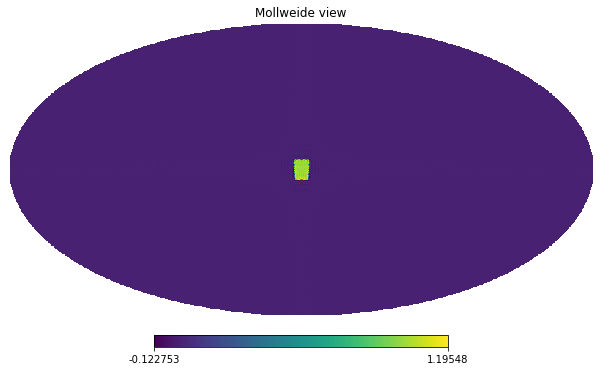

In [851]:
# Test code for seeing how to do rotations correctly.

test_map = np.zeros(egsm_npix)
ra, dec = healpy.pix2ang(egsm_nside, egsm_ipix, lonlat=True)
select = (np.abs(dec - obs_dec*180/np.pi) < 5) & (np.abs(ra - obs_lst*180/np.pi) < 5)
test_map[select] = 1
test_alm = healpy.sphtfunc.map2alm(test_map, use_pixel_weights=True)
healpy.rotator.rotate_alm(test_alm, psi=-obs_lst, theta=obs_dec-np.pi/2)
rot_map = healpy.sphtfunc.alm2map(test_alm, egsm_nside)
healpy.mollview(rot_map, rot=(0,90,0))  # patch should be in the center of the map

In [771]:
# Some bookkeeping in case the HEALPix maps have different n_side
egsm_lmax = 3*egsm_nside - 1
uvb_lmax = 3*uvb_nside - 1
lmax = min(egsm_lmax, uvb_lmax)

In [772]:
# Rotate our map to be in the same coordinate system as the beam map, then get the power spectrum
ref_map = egsm_stokes[0,np.argmin(np.abs(egsm_freqs - select_freq))]
ref_alm = healpy.sphtfunc.map2alm(ref_map, use_pixel_weights=True)
healpy.rotator.rotate_alm(ref_alm, psi=-obs_lst, theta=obs_dec-np.pi/2, phi=0)
ref_map = healpy.sphtfunc.alm2map(ref_alm, egsm_nside)
ref_cls = healpy.sphtfunc.anafast(ref_map, lmax=lmax, use_pixel_weights=True)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [773]:
hpx_uvbeam.data_array.shape

(1, 1, 2, 76, 196608)

In [774]:
fringe = np.exp(-2j * np.pi * sorted_uvws[edges[0]] @ pix_vecs)
phased_beam = ref_beam * fringe
beam_cls = healpy.sphtfunc.anafast(phased_beam, lmax=lmax, use_pixel_weights=True)

Casting complex values to real discards the imaginary part


## Note: vis_cpu uses $b_{ij} = x_i - x_j$

In [775]:
# Now let's build the diffuse matrix, assuming no overlap between redundant groups
diff_mat = np.zeros((uvdata.Nbls, edges.size-1), dtype=complex)
freq_ind = np.argmin(np.abs(hpx_uvbeam_freqs - select_freq))
ref_beam = hpx_uvbeam.data_array[0,0,0,freq_ind,:]
pix_vecs = np.array(healpy.pix2vec(uvb_nside, uvb_ipix))
for grp, (start, stop) in enumerate(zip(edges, edges[1:])):
    phase = 2j * np.pi * sorted_uvws[start] @ pix_vecs
    fringe = np.exp(phase)
    phased_beam = ref_beam * fringe
    beam_cls = healpy.sphtfunc.anafast(phased_beam, lmax=lmax, use_pixel_weights=True)
    block_amp = np.sqrt(
        np.sum(ref_cls * beam_cls * (2*np.arange(lmax+1) + 1))
    )
    diff_mat[start:stop,grp] = block_amp

In [776]:
# Now to construct the source matrix. First, we need to modify the source positions
src_ra = gleam_model.ra.to('rad').value
src_dec = gleam_model.dec.to('rad').value
obstime = Time(uvdata.time_array[0], format='jd')
obsloc = EarthLocation.from_geodetic(*uvdata.telescope_location_lat_lon_alt)
src_eci_ra, src_eci_dec = vis_cpu.conversions.equatorial_to_eci_coords(
    src_ra,
    src_dec,
    obstime,
    obsloc,
)

# Now rotate to local (ENU) coordinates
Nsrc = src_ra.size
src_pos = np.zeros((Nsrc, 3), dtype=float)
src_pos[:,0] = np.cos(src_eci_ra) * np.cos(src_eci_dec)
src_pos[:,1] = np.sin(src_eci_ra) * np.cos(src_eci_dec)
src_pos[:,2] = np.sin(src_eci_dec)
eci_to_enu = vis_cpu.conversions.eci_to_enu_matrix(obs_lst, obs_dec)
enu_src_pos = eci_to_enu @ src_pos.T
enu_src_pos = enu_src_pos.T
horizon_cut = enu_src_pos[:,2] > 0
enu_src_pos = enu_src_pos[horizon_cut,:]
Nsrc = horizon_cut.sum()

In [816]:
power_beam.data_array.shape

(1, 1, 2, 76, 181, 360)

In [831]:
# Interpolate the beam to each source position
az, za = vis_cpu.conversions.enu_to_az_za(enu_src_pos[:,0], enu_src_pos[:,1], "uvbeam")
# power_beam = uvbeam.efield_to_power(calc_cross_pols=False, inplace=False)
# power_beam.peak_normalize()
# interp_beam = power_beam.interp(az_array=az, za_array=za, reuse_spline=True)[0]
# interp_beam = interp_beam[0,0,0,np.argmin(np.abs(uvbeam_freqs - select_freq))]
interp_beam = uvbeam.interp(az_array=az, za_array=za, reuse_spline=True)[0]
# Convert to power beam
interp_beam = np.einsum("nikl,njkl->ijkl", interp_beam.squeeze(), interp_beam.squeeze().conj())
# Here we just want the XX polarization and whatever frequency we're at
interp_beam = interp_beam[0,0,np.argmin(np.abs(uvbeam_freqs - select_freq))]

In [833]:
# Actually construct the source matrix
src_mat = np.zeros((uvdata.Nbls, Nsrc), dtype=complex)
src_flux = 0.5 * gleam_model.stokes[0,0,horizon_cut].to("Jy").value  # I = (XX + YY) / 2
obs_flux = src_flux * interp_beam
# Source matrix is observed flux times fringe at each baseline/source
src_mat = obs_flux.reshape(1,-1) * np.exp(2j * np.pi * sorted_uvws @ enu_src_pos.T)

In [779]:
# Sanity check: brightest part should be source 6 (it's in the main lobe)
# plt.imshow(np.log10(np.abs(src_mat)), aspect='auto', interpolation='none')
# plt.colorbar()

In [780]:
# Some setup before calibration

In [781]:
snr = 1000
noise_amp = np.abs(data).max() / snr
noise = np.eye(uvdata.Nbls, dtype=complex) * noise_amp**2
noise_diag = np.diag(noise)

n_ants = antenna_numbers.size
err = 0.05
re_gain = np.random.normal(loc=1, size=n_ants, scale=err)
im_gain = np.random.normal(loc=0, size=n_ants, scale=err)
split_gains = np.zeros(2*n_ants, dtype=float)
split_gains[::2] = re_gain
split_gains[1::2] = im_gain

In [782]:
# Copypasta stuff because I'm lazy

In [783]:
class Cov:
    def __init__(self, noise, diff_mat, src_mat, gains, edges, ant_1_inds, ant_2_inds):
        self.noise = noise
        self.diff_mat = diff_mat
        self.src_mat = src_mat
        self.gains = gains
        self.edges = edges
        self.ant_1_inds = ant_1_inds
        self.ant_2_inds = ant_2_inds
        self.n_bls = diff_mat.shape[0]
        self.n_grp = len(edges) - 1
        self.n_eig = diff_mat.shape[1] // self.n_grp
        self.n_src = src_mat.shape[1]
    
    def inv(self, dense=False, return_det=False):
        return self._dense_inv(return_det) if dense else self._sparse_inv(return_det)
    
    def _dense_inv(self, return_det=False):
        gain_mat = self.build_gain_mat()
        sky_cov = self.src_mat@self.src_mat.T.conj() + self.diff_mat@self.diff_mat.T.conj()
        full_cov = self.noise + gain_mat[:,None]*sky_cov*gain_mat[None,:].conj()
        inv = np.linalg.inv(full_cov)
        if return_det:
            try:
                logdet = 2*np.sum(np.log(np.diag(np.linalg.cholesky(full_cov))))
            except np.linalg.LinAlgError:
                logdet = np.inf
            return inv, np.real(logdet)
        return inv
    
    def _sparse_inv(self, return_det=False):
        if return_det:
            logdet = 0
            
        gain_mat = self.build_gain_mat()
        Cinv = np.zeros((self.n_bls, self.n_bls), dtype=complex)
        GD = gain_mat[:,None] * self.diff_mat
        for grp, (start, stop) in enumerate(zip(self.edges, self.edges[1:])):
            left = grp * self.n_eig
            right = left + self.n_eig
            
            block = GD[start:stop, left:right].copy()
            block = self.noise[start:stop,start:stop] + block@block.T.conj()
            if return_det:
                logdet += 2*np.sum(np.log(np.diag(np.linalg.cholesky(block))))
            Cinv[start:stop,start:stop] = np.linalg.inv(block)
            
        GS = gain_mat[:,None] * self.src_mat
        CGS = Cinv @ GS
        tmp = np.eye(self.n_src) + GS.T.conj()@CGS
        Cinv -= CGS @ np.linalg.inv(tmp) @ CGS.T.conj()
        
        if return_det:
            logdet += 2 * np.sum(np.log(np.diag(np.linalg.cholesky(tmp))))
            return Cinv, np.real(logdet)
        return Cinv
       
    def build_gain_mat(self):
        gains = self.gains[::2] + 1j*self.gains[1::2]
        return gains[self.ant_1_inds] * gains[self.ant_2_inds].conj()

In [784]:
def nll(gains, cov, data, scale=1, phs_norm_fac=1):
    """Negative log-likelihood."""
    cov.gains = gains / scale
    cinv, logdet = cov.inv(dense=False, return_det=True)
    chisq = data.conj() @ cinv @ data
    # Use a Gaussian prior that the phase should be nearly zero for all antennas
    phases = np.arctan2(cov.gains[1::2], cov.gains[::2])
    phs_norm = phases.sum()**2 / phs_norm_fac**2
#     phs_norm = cov.gains[1::2].sum()**2 / phs_norm_fac**2
    return np.real(chisq) + logdet + phs_norm

In [785]:
def grad_nll(gains, cov, data, scale=1, phs_norm_fac=1):
    """Gradient of negative log-likelihood."""
    cov.gains = gains / scale
    complex_gains = (gains[::2] + 1j*gains[1::2]) / scale
    gain_mat = cov.build_gain_mat()
    cinv = cov.inv(dense=False, return_det=False)
    cinv_data = cinv @ data
    grad_nll = np.zeros_like(gains)
    tan_phs = cov.gains[1::2] / cov.gains[::2]
    phases = np.arctan2(cov.gains[1::2], cov.gains[::2])
    grad_phs_prefac = 2 * phases.sum() / (phs_norm_fac**2 * cov.gains[::2] * (1+tan_phs**2))
    for k in range(gains.size):
        grad_chisq = 0
        grad_gains = np.zeros_like(gain_mat)
        if k%2 == 0:  # derivative wrt real gain
            grad_gains += np.where(cov.ant_1_inds == k//2, complex_gains[cov.ant_2_inds].conj(), 0)
            grad_gains += np.where(cov.ant_2_inds == k//2, complex_gains[cov.ant_1_inds], 0)
            grad_phs_norm = -grad_phs_prefac[k//2] * cov.gains[k+1] / cov.gains[k]
#             grad_phs_norm = 0
        else:
            grad_gains += np.where(cov.ant_1_inds == k//2, 1j*complex_gains[cov.ant_2_inds].conj(), 0)
            grad_gains += np.where(cov.ant_2_inds == k//2, -1j*complex_gains[cov.ant_1_inds], 0)
            grad_phs_norm = grad_phs_prefac[k//2]
#             grad_phs_norm = 2 * cov.gains[1::2].sum() / phs_norm_fac**2
        tmp1 = grad_gains[:,None] * cov.src_mat
        tmp2 = cov.src_mat.T.conj() * gain_mat[None,:].conj()
        grad_cov = tmp1 @ tmp2
        tmp1 = cinv_data.conj() @ tmp1
        tmp2 = tmp2 @ cinv_data
        grad_chisq += tmp1 @ tmp2
        tmp1 = grad_gains[:,None] * cov.diff_mat
        tmp2 = cov.diff_mat.T.conj() * gain_mat[None,:].conj()
        grad_cov += tmp1 @ tmp2
        tmp1 = cinv_data.conj() @ tmp1
        tmp2 = tmp2 @ cinv_data
        grad_chisq += tmp1 @ tmp2
        grad_cov = grad_cov + grad_cov.T.conj()
        grad_logdet = np.sum(cinv * grad_cov.T)
        grad_nll[k] = np.real(grad_logdet - 2*grad_chisq + grad_phs_norm)  # actually calculated -grad_chisq/2, so this is right
    return grad_nll / scale

In [834]:
cov = Cov(
    noise=noise,
    diff_mat=diff_mat*0,
    src_mat=src_mat,
    gains=split_gains,
    edges=edges,
    ant_1_inds=sorted_ant_1_inds,
    ant_2_inds=sorted_ant_2_inds,
)

In [812]:
scale = 1
phs_norm_fac = 1e-1

In [835]:
result = minimize(
    nll,
    scale*split_gains,
    args=(cov, sorted_data, scale, phs_norm_fac),
    method="CG",
    jac=grad_nll,
)

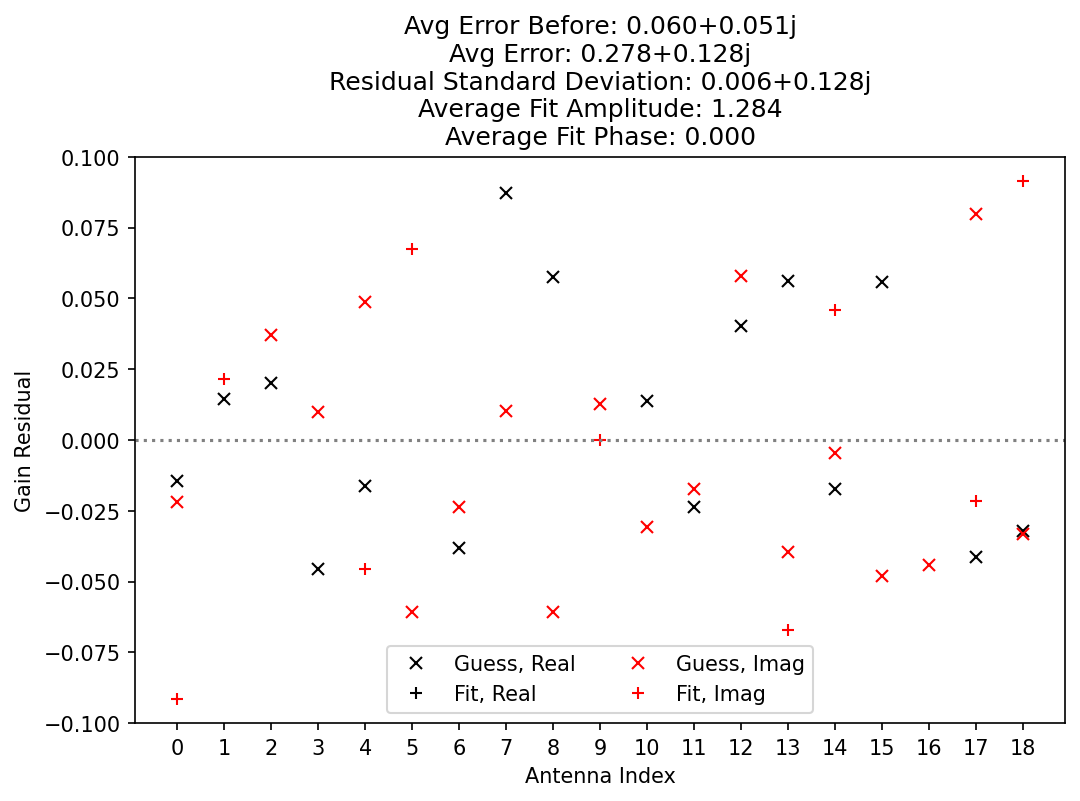

In [836]:
fit = (result.x[::2] + 1j*result.x[1::2]) / scale
def err(val, exp):
    return np.sqrt(np.mean((val - exp)**2))
avg_err_before = err(split_gains[::2], 1) + 1j*err(split_gains[1::2], 0)
avg_err = err(fit.real, 1) + 1j*err(fit.imag, 0)
fit_std = np.std(fit.real) + 1j*np.std(fit.imag)
lim = 0.1
plt.figure(figsize=(8,5),dpi=150, facecolor='white')
title = f"Avg Error Before: {avg_err_before:.3f}\n"
title += f"Avg Error: {avg_err:.3f}\n"
title += f"Residual Standard Deviation: {fit_std:.3f}\n"
title += f"Average Fit Amplitude: {np.mean(np.abs(fit)):.3f}\n"
title += f"Average Fit Phase: {np.mean(np.angle(fit)):.3f}"
plt.title(title)
plt.plot(split_gains[::2] - 1, 'kx', label='Guess, Real')
plt.plot(fit.real - 1, 'k+', label='Fit, Real')
plt.plot(split_gains[1::2], 'rx', label='Guess, Imag')
plt.plot(fit.imag, 'r+', label='Fit, Imag')
plt.ylim(-lim,lim)
plt.axhline(0, color='gray', ls=':')
plt.legend(ncol=2)
plt.xlabel("Antenna Index")
plt.ylabel("Gain Residual")
plt.xticks(np.arange(n_ants));
# plt.savefig(f"example_sol_comparison_complex_src_mat_only_zenith_src_scale_{scale}.png", dpi=150, bbox_inches='tight')
# plt.savefig("example_three_src_sol_with_noise.png", dpi=150, bbox_inches="tight")

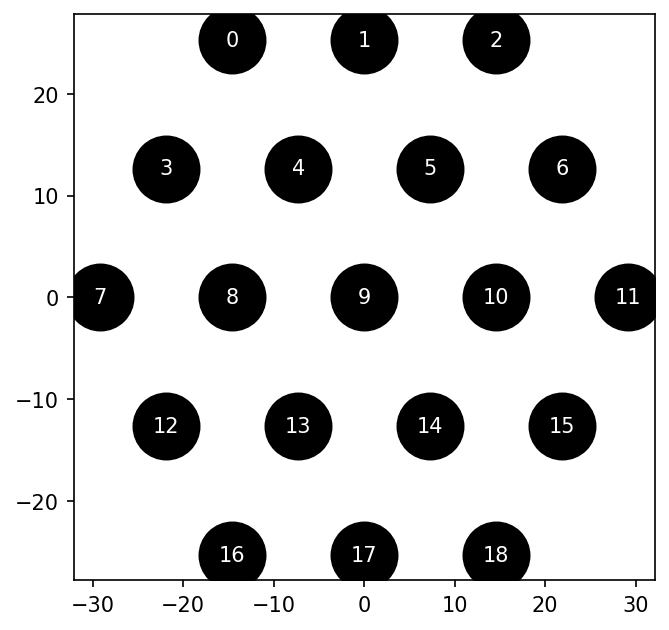

In [790]:
plt.figure(figsize=(5,5),dpi=150)
plt.scatter(*antpos.T[:2], marker='o', color='k', s=1000)
for i, (x,y,z) in enumerate(antpos):
    plt.text(x,y,i,color='w',ha='center',va='center')

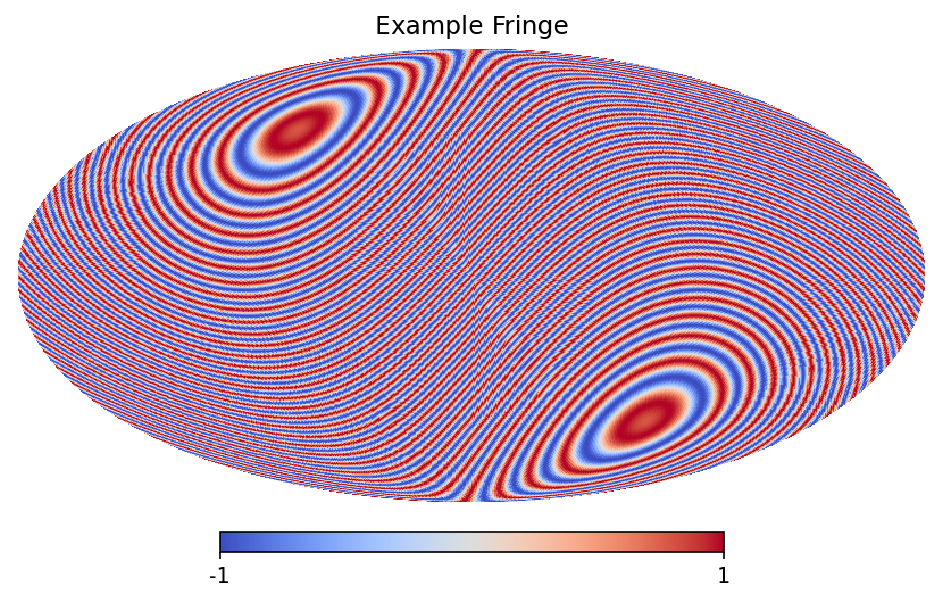

In [859]:
longest_uvw = sorted_uvws[np.argmax(np.linalg.norm(sorted_uvws, axis=1))]
ew_uvw = sorted_uvws[np.argmin(np.abs(sorted_uvws[:,1]))]
select_uvw = sorted_uvws[edges[0]]
fringe = np.exp(-2j * np.pi * select_uvw @ pix_vecs)
plt.figure(figsize=(7,4), dpi=150, facecolor='w')
healpy.mollview(fringe.real, rot=(0,90,0), title="Example Fringe", fig=1, cmap='coolwarm')
plt.savefig("example_fringe.png", dpi=150, bbox_inches="tight")

# Lessons Learned
This was a fun experiment, but it was maybe a bit much to jump directly in the deep end. This will serve as a useful reference for building infrastructure, but it's important to carefully build out from the basics.

In [837]:
data_cov = np.outer(sorted_data, sorted_data.conj())
model_cov = src_mat @ src_mat.T.conj()

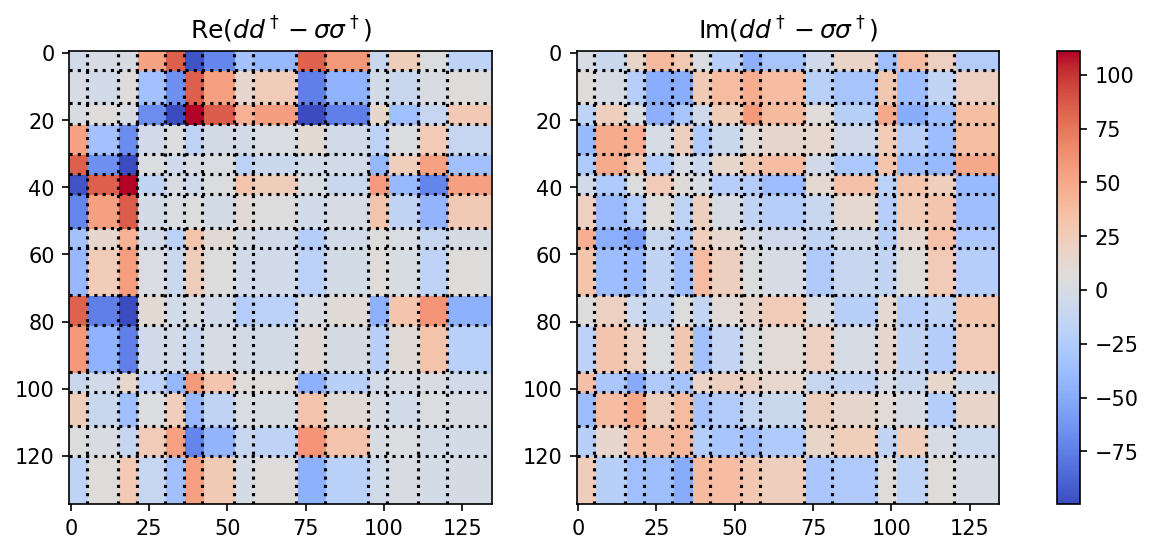

In [852]:
cov_diff = data_cov - model_cov
fig, axes = plt.subplots(1,2,dpi=150,figsize=(10,4),facecolor='w')
vmin = min(cov_diff.real.min(), cov_diff.imag.min())
vmax = max(cov_diff.real.max(), cov_diff.imag.max())
norm = plt.cm.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.coolwarm
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
axes[0].imshow(cov_diff.real, norm=norm, cmap=cmap, aspect='auto')
axes[1].imshow(cov_diff.imag, norm=norm, cmap=cmap, aspect='auto')
fig.colorbar(smap, ax=axes)
for edge in edges[1:-1]:
    for ax in axes:
        ax.axhline(edge-1, color='k', ls=':')
        ax.axvline(edge-1, color='k', ls=':')
axes[0].set_title(r"Re$(dd^\dagger - \sigma\sigma^\dagger)$")
axes[1].set_title(r"Im$(dd^\dagger - \sigma\sigma^\dagger)$");
fig.savefig("data_vs_model_covariance.png", dpi=150, bbox_inches="tight")

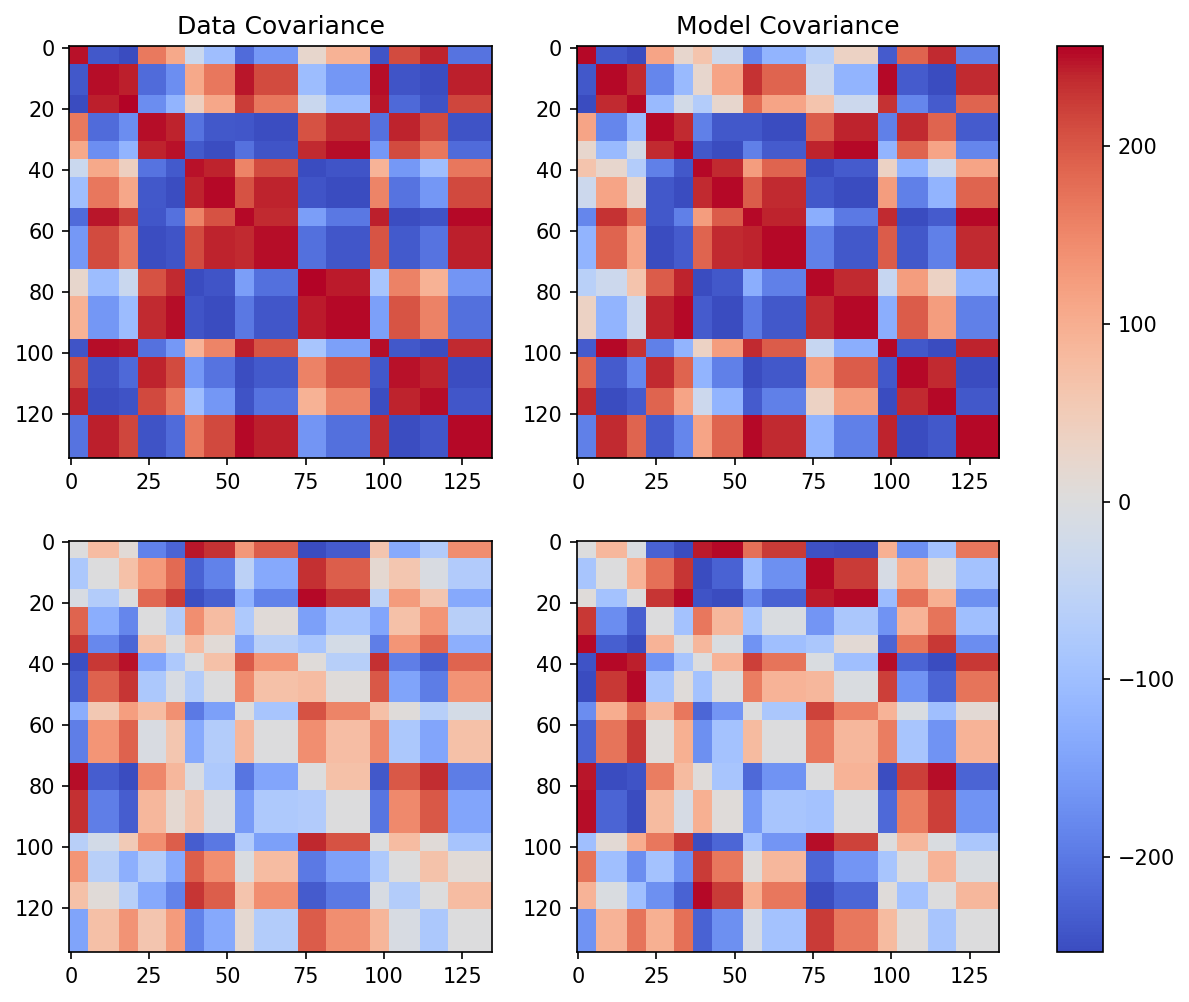

In [838]:
fig, axes = plt.subplots(2,2, dpi=150, figsize=(10,8), facecolor='w')
vmin = min(model_cov.real.min(), model_cov.imag.min(), data_cov.real.min(), data_cov.imag.min())
vmax = max(model_cov.real.max(), model_cov.imag.max(), data_cov.real.max(), data_cov.imag.max())
# vmin = min(np.abs(model_cov).min(), np.abs(data_cov).min())
# vmax = max(np.abs(model_cov).max(), np.abs(data_cov).max())
norm = plt.cm.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.coolwarm
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
axes[0,0].imshow(np.real(data_cov), norm=norm, cmap=cmap, aspect='auto')
axes[0,1].imshow(np.real(model_cov), norm=norm, cmap=cmap, aspect='auto')
axes[1,0].imshow(np.imag(data_cov), norm=norm, cmap=cmap, aspect='auto')
axes[1,1].imshow(np.imag(model_cov), norm=norm, cmap=cmap, aspect='auto')
axes[0,0].set_title("Data Covariance")
axes[0,1].set_title("Model Covariance")
fig.colorbar(smap, ax=axes);